In [2]:
import sys
sys.path.append('../')
from lib.input_const import *
from lib.perfeval import PaymentStoriesPerformanceEvaluator
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import matplotlib as mpl
import pandas as pd
import pyarrow.parquet as pq
import pyarrow.compute as pc
input_code = "202212"

In [3]:
pd.set_option('display.max_rows', 110)
pd.set_option('display.max_columns', 30)

____

# Calculate overall numbers

In [15]:
pdelay_full = pq.read_table(pay_delay_with_debts_file(input_code))

In [ ]:
pdelay_full.column("legal_entity_id").count_values()

In [20]:

def _bin(f: float, t: float) -> int:
    return pdelay_full.filter((pc.field("delay_days") > f) & ((pc.field("delay_days") <= t))).num_rows


In [26]:
_bins_lowers = range(-60, 180)
_bins = [(_bin(_f, _t), _t) for _f, _t in zip(_bins_lowers[:-1], _bins_lowers[1:])]
_first = pdelay_full.filter(pc.field("delay_days") <= min(_bins_lowers)).num_rows
_last = pdelay_full.filter(pc.field("delay_days") > max(_bins_lowers)).num_rows
_bins = [(_first, min(_bins_lowers))]+_bins+[(_last, max(_bins_lowers)+1)]

In [ ]:
_bins

Text(0, 0.5, '%')

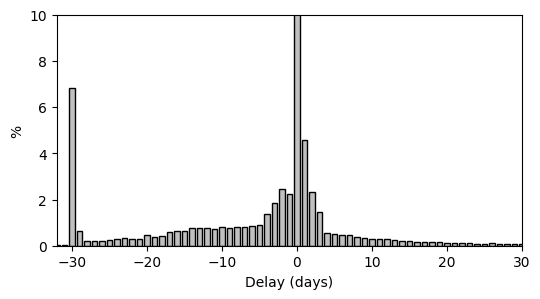

In [64]:
fig, ax = plt.subplots(figsize=(6,3))
bars = ax.bar([_b[1] for _b in _bins], [100*_b[0]/pdelay_full.num_rows for _b in _bins], width=0.7, color='silver', edgecolor='black')
ax.set_ylim(0, 10)
ax.set_xlim(-32, 30)
ax.set_xlabel("Delay (days)")
ax.set_ylabel("%")

___

# Per-source details

In [8]:
report = pd.read_csv(report_overview_file(input_code), index_col=[0])

In [9]:
report

,industry,records-count-all,records-count-wo-outliers,entities-count,entities-with-later-debt,entities-with-later-severe-debt,sociodemographic-age-mean,sociodemographic-age-stddev,sociodemographic-age-skewness,sociodemographic-m-w-ratio,sociodemographic-unknown-gender-ratio,amount-mean,amount-stddev,amount-count-unknown,amount-count-too-high,payment-days-diff-mean,payment-days-diff-stddev,payment-prepaid-days-mean,payment-prepaid-days-stddev,payment-prepaid-days-count,payment-delayed-days-mean,payment-delayed-days-stddev,payment-delayed-days-count,payment-on-time-count
Adbouti,COMPUTING,25739,25723,12832,1208,281,52.143670,14.116381,0.293536,1.680527,0.095698,3308.265607,8797.254821,4,57,4.354780,34.527702,-17.379260,10.229324,13616,30.642819,36.227364,11378,729
Addis,COLLECTION,69719246,69718491,2879096,277710,69664,51.130532,16.844818,0.007749,1.058606,0.003681,NaN,NaN,69718491,0,-1.061049,5.721659,-29.819211,2.170643,2513295,34.444642,53.593544,28153,67177043
Adiningo,UNKNOWN,8507,8473,6910,433,112,55.841166,15.675461,0.117455,1.122557,0.009986,412.531912,3842.862298,9,19,-16.192848,21.372268,-21.231702,8.766257,7501,24.372376,42.002151,905,67
Alparal,BUILDING,22997,22997,10979,1280,274,55.635696,16.690248,0.277749,1.724208,0.028327,2018.771620,5792.882308,0,9,-12.813845,22.105732,-21.174070,7.927887,18326,21.377605,28.910181,4367,304
Apacun,UNKNOWN,4099428,4099428,885820,174756,44375,43.280281,14.628062,0.771140,0.346273,0.006999,NaN,NaN,4099428,0,-30.000000,0.000000,-30.000000,0.000000,4099428,NaN,NaN,0,0
Artersy,UNKNOWN,54809,52677,11051,1884,428,48.120036,15.042537,-0.390889,0.964951,0.188309,213.110242,432.671182,11,0,1.853484,51.076075,-16.589590,8.460042,37789,51.265832,78.618419,14133,755
Beracdi,B2B,243588,242882,107689,14565,2693,43.420719,14.864745,0.364669,0.816743,0.032102,111.066690,141.842914,57,0,-4.983576,20.354774,-14.892201,7.825324,162135,17.068906,23.878291,70545,10202
Berapes,UNKNOWN,250193,250018,128767,14256,1100,37.752545,10.911892,0.435538,0.245769,0.003052,91.760123,80.375588,11,0,1.486133,13.931091,-4.608734,2.755378,119696,8.398212,18.560598,109929,20393
Bernev,CONSIGNMENT,1312964,1312964,281239,59627,21284,51.317688,15.671795,0.275507,0.515905,0.003684,125.175306,186.093391,75,0,0.000000,0.000000,NaN,NaN,0,NaN,NaN,0,1312964
Bertleu,B2B,19942,19905,1357,71,11,51.141825,13.569212,-0.358029,16.970149,0.112749,1521.959469,5501.688092,0,19,-11.816780,23.433343,-24.359151,12.496976,12343,9.506463,23.603795,6885,677


In [10]:
COL_COUNT_ALL='Records (k)'
COL_OUTLIERS = 'Outliers (\%)'
COL_PER_ENTITY = 'Records per entity'
# COL_RISK_RATE = 'Mild risk rate'
COL_AVG_DELAY = 'Delay: mean'
COL_STDDEV_DELAY = 'Delay: stddev'
COL_AMOUNT_MISSING = 'Missing amount (\%)'

In [14]:
report[COL_COUNT_ALL] = report[OverviewReportColNames.RecordsCountAll] / 1000.0
report[COL_OUTLIERS] = 100.0 * (report[OverviewReportColNames.RecordsCountAll] - report[OverviewReportColNames.RecordsCountWithoutOutliers]) / report[OverviewReportColNames.RecordsCountAll]
report[COL_PER_ENTITY] = report[OverviewReportColNames.RecordsCountWithoutOutliers] / report[OverviewReportColNames.EntitiesCount]
report[COL_AVG_DELAY] = report[OverviewReportColNames.PaymentDaysMean]
report[COL_STDDEV_DELAY] = report[OverviewReportColNames.PaymentDaysStddev]
report[COL_AMOUNT_MISSING] = 100.0 * report[OverviewReportColNames.AmountUnknownCount] / report[OverviewReportColNames.RecordsCountWithoutOutliers]

In [18]:
report[[COL_COUNT_ALL, COL_OUTLIERS, COL_PER_ENTITY, COL_AVG_DELAY, COL_STDDEV_DELAY, COL_AMOUNT_MISSING]].sort_values([COL_COUNT_ALL], ascending=False).head(50)

,Records (k),Outliers (\%),Records per entity,Delay: mean,Delay: stddev,Missing amount (\%)
Addis,69719.246,0.001083,24.215410,-1.061049,5.721659,100.000000
Estry,36659.549,0.001116,24.452077,-1.122091,8.663862,0.017101
Ganpe,14364.531,0.000000,15.426010,0.000000,0.000000,0.005416
Tionse,8361.151,0.023095,7.407904,-0.223942,26.221109,0.134893
Parfae,8136.744,0.010913,6.101070,-7.513751,13.519356,0.238094
Otheso,6501.804,0.000000,7.669302,0.000000,0.000000,0.375465
Ningui,4922.236,0.000000,5.824394,-30.000000,0.000000,0.000020
Apacun,4099.428,0.000000,4.627834,-30.000000,0.000000,100.000000
Everna,3913.966,0.754452,2.608791,6.015259,45.009716,0.001339
Picfio,3311.629,0.000000,22.772701,-2.758926,13.260710,0.057041


____

# The profiles

In [24]:
import numpy as np

In [19]:
report = pd.read_csv(report_overview_file(input_code), index_col=[0])

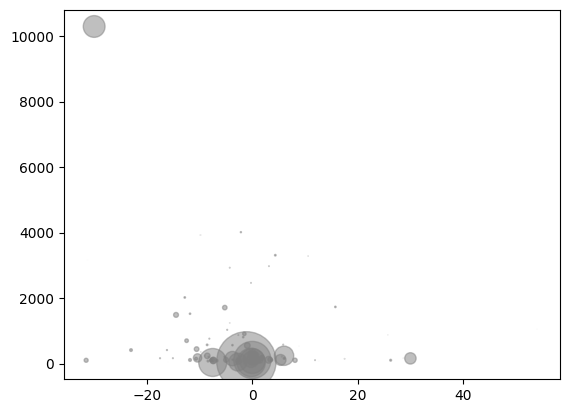

In [77]:
having_amount = report.loc[(report[OverviewReportColNames.AmountUnknownCount] / report[OverviewReportColNames.RecordsCountWithoutOutliers]) < 0.1]

fig, ax = plt.subplots()
ax.scatter(
    x=having_amount[OverviewReportColNames.PaymentDaysMean], 
    y=having_amount[OverviewReportColNames.AmountMean], 
    s=(having_amount[OverviewReportColNames.RecordsCountWithoutOutliers])/20000, 
    c='gray',
    alpha=0.5
)
# comment the limits to un-zoom
# ax.set_ylim(0, 500)
# ax.set_xlim(-20, 10)



Text(0.5, 0.02, 'Average delay (days)')

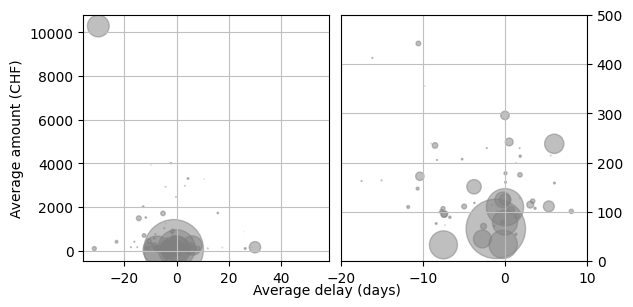

In [105]:
having_amount = report.loc[(report[OverviewReportColNames.AmountUnknownCount] / report[OverviewReportColNames.RecordsCountWithoutOutliers]) < 0.1]

fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.2), gridspec_kw={"wspace": 0.05})
for ax in axs:
    ax.scatter(
        x=having_amount[OverviewReportColNames.PaymentDaysMean], 
        y=having_amount[OverviewReportColNames.AmountMean], 
        s=(having_amount[OverviewReportColNames.RecordsCountWithoutOutliers])/20000, 
        c='gray',
        alpha=0.5
    )
    ax.grid(True, color='silver')
    # ax.set_xlabel("Average delay (days)")

axs[0].set_ylabel("Average amount (CHF)")
axs[1].set_ylim(0, 500)
axs[1].set_xlim(-20, 10)
axs[1].yaxis.tick_right()
fig.text(0.5, 0.02, 'Average delay (days)', ha='center', va='center')


___

# Variability 
In order to check whether the sources follow similar - or different - pattern regarding how variable the data are,
on left-hand side figure variability of delay is confronted with variability of
invoiced amount for each source.
On the right-hand the variability of delay was shown in function of the average delay

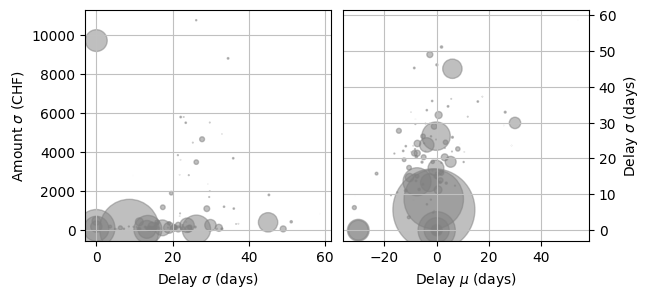

In [113]:
report = pd.read_csv(report_overview_file(input_code), index_col=[0])
having_amount = report.loc[
    (report[OverviewReportColNames.AmountUnknownCount] / report[OverviewReportColNames.RecordsCountWithoutOutliers])
    < 0.1]
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3), gridspec_kw={"wspace": 0.05})
axs[0].scatter(
    x=having_amount[OverviewReportColNames.PaymentDaysStddev],
    y=having_amount[OverviewReportColNames.AmountStandardDeviation],
    s=(having_amount[OverviewReportColNames.RecordsCountWithoutOutliers])/20000, 
    c='gray',
    alpha=0.5
)
axs[0].set_ylabel("Amount $\sigma$ (CHF)")
axs[0].set_xlabel("Delay $\sigma$ (days)")
axs[0].grid(True, color='silver')

axs[1].scatter(
    x=report[OverviewReportColNames.PaymentDaysMean],
    y=report[OverviewReportColNames.PaymentDaysStddev],
    s=(report[OverviewReportColNames.RecordsCountWithoutOutliers])/20000, 
    c='gray',
    alpha=0.5
)
axs[1].tick_params(axis='y', right=True, labelright=True, labelleft=False, left=False)
axs[1].yaxis.set_label_position("right")
axs[1].set_ylabel("Delay $\sigma$ (days)")
axs[1].set_xlabel("Delay $\mu$ (days)")
axs[1].grid(True, color='silver')


# Risk rate

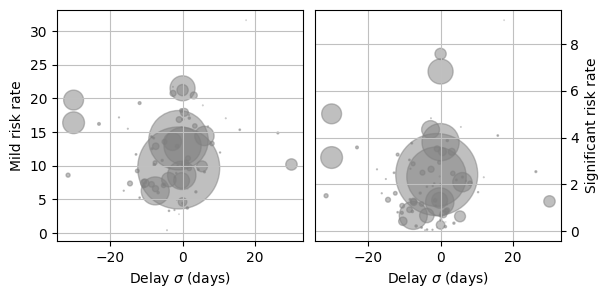

In [119]:
report = pd.read_csv(report_overview_file(input_code), index_col=[0])
report = report.loc[report[OverviewReportColNames.EntitiesCount] > 1000]

fig, axs = plt.subplots(1, 2, figsize=(6.5, 3), gridspec_kw={"wspace": 0.05})
axs[0].scatter(
    x=report[OverviewReportColNames.PaymentDaysMean],
    y=100.0 * report[OverviewReportColNames.EntitiesWithLaterDebt] / report[OverviewReportColNames.EntitiesCount],
    s=(report[OverviewReportColNames.RecordsCountWithoutOutliers])/20000, 
    c='gray',
    alpha=0.5
)
axs[0].set_ylabel("Mild risk rate")
axs[0].set_xlabel("Delay $\sigma$ (days)")
axs[0].grid(True, color='silver')

axs[1].scatter(
    x=report[OverviewReportColNames.PaymentDaysMean],
    y=100.0 * report[OverviewReportColNames.EntitiesWithLaterSevereDebt] / report[OverviewReportColNames.EntitiesCount],
    s=(report[OverviewReportColNames.RecordsCountWithoutOutliers])/20000, 
    c='gray',
    alpha=0.5
)
axs[1].tick_params(axis='y', right=True, labelright=True, labelleft=False, left=False)
axs[1].yaxis.set_label_position("right")
axs[1].set_ylabel("Significant risk rate")
axs[1].set_xlabel("Delay $\sigma$ (days)")
axs[1].grid(True, color='silver')



___

# Stories - examples

In [121]:
report = pd.read_csv(report_predictors(input_code), index_col=[0])

In [124]:
report.sort_values('story-length-mean', ascending=False)

,stories-count,story-length-mean,story-duration-mean,stories-per-entity,risk-rate,significant-risk-rate,delay-days-scaled-mean-mean,delay-days-scaled-mean-median,delay-days-scaled-mean-stddev,delay-days-scaled-mean-count-valid,delay-days-scaled-mean-denotes-any-risk-ROC-AUC,delay-days-scaled-mean-denotes-any-risk-F1-max,delay-days-scaled-mean-denotes-any-risk-F1-max-threshold,delay-days-scaled-mean-denotes-significant-risk-ROC-AUC,delay-days-scaled-mean-denotes-significant-risk-F1-max,...,regression-line-a1-for-delay-denotes-any-risk-F1-max,regression-line-a1-for-delay-denotes-any-risk-F1-max-threshold,regression-line-a1-for-delay-denotes-significant-risk-ROC-AUC,regression-line-a1-for-delay-denotes-significant-risk-F1-max,regression-line-a1-for-delay-denotes-significant-risk-F1-max-threshold,regression-line-a1-for-severity-mean,regression-line-a1-for-severity-median,regression-line-a1-for-severity-stddev,regression-line-a1-for-severity-count-valid,regression-line-a1-for-severity-denotes-any-risk-ROC-AUC,regression-line-a1-for-severity-denotes-any-risk-F1-max,regression-line-a1-for-severity-denotes-any-risk-F1-max-threshold,regression-line-a1-for-severity-denotes-significant-risk-ROC-AUC,regression-line-a1-for-severity-denotes-significant-risk-F1-max,regression-line-a1-for-severity-denotes-significant-risk-F1-max-threshold
Blebout,10261,33.042199,1328.629081,1.188441,0.169964,0.037423,-0.006220,-0.241821,0.805349,10261,0.761464,0.479466,0.246498,0.738973,0.225352,...,0.363807,0.001155,0.546242,0.204724,0.007298,0.000273,-3.405935e-06,0.051525,7973,0.538929,0.327329,0.003364,0.542582,0.184397,0.010011
Vertlei,4872,28.049261,1639.848112,1.127256,0.111043,0.026273,0.227185,0.217754,0.780941,4872,0.679227,0.333333,0.557055,0.649505,0.112434,...,0.234266,0.001473,0.457540,0.152672,0.009286,0.000815,1.315213e-04,0.086890,3382,0.537828,0.264095,0.002275,0.537733,0.149068,0.012858
Addis,2990222,23.315490,357.548500,1.038598,0.039851,0.011529,-1.653121,-0.274534,2.281483,2990222,0.638422,0.129988,0.183998,0.659621,0.048823,...,0.102986,-0.000114,0.502252,0.037597,-0.000114,-0.004175,-1.202929e-03,0.006768,1557010,0.441587,0.102986,-0.000114,0.502252,0.037597,-0.000114
Estry,1752963,20.912672,1125.714539,1.169247,0.172848,0.034651,-0.033469,0.043193,0.775221,1752963,0.583037,0.354442,0.474921,0.594080,0.201510,...,0.322848,0.001179,0.510457,0.143631,0.003757,0.000570,2.652407e-04,0.022067,1571913,0.547610,0.343035,0.003245,0.513424,0.155961,0.011202
Picfio,160143,20.679199,1232.457816,1.101237,0.119518,0.039665,0.044729,-0.017792,0.921131,160143,0.636399,0.288219,0.356993,0.632034,0.140746,...,0.234367,0.000754,0.492493,0.120902,0.002404,-0.000366,-3.408505e-07,0.030796,137630,0.493523,0.248721,0.003329,0.487437,0.135348,0.005602
Mentdis,31613,20.249423,1464.042166,1.153338,0.167906,0.032234,0.295072,-0.016797,1.177626,31613,0.666751,0.369855,0.255504,0.667317,0.161630,...,0.294782,-0.023514,0.431981,0.133883,0.002000,0.000239,-1.354057e-05,0.025873,22603,0.467663,0.300194,0.001838,0.446497,0.138985,0.003888
Tainpeo,1445,14.991003,225.253979,1.053975,0.063668,0.027682,-0.219900,-0.380292,0.654796,1445,0.834695,0.494118,1.037309,0.823345,0.353982,...,0.299213,0.008507,0.487704,0.266667,0.027432,0.003050,2.713239e-04,0.063306,808,0.474430,0.302158,0.010647,0.417331,0.238806,0.025840
Bertleu,1413,14.087049,497.378627,1.041268,0.034678,0.007077,-0.161088,-0.346457,0.902895,1413,0.785265,0.235808,0.597343,0.932502,0.347826,...,0.091864,-0.008300,0.278610,0.054054,0.004477,0.000337,-2.617342e-04,0.033013,739,0.392084,0.117647,0.002357,0.440327,0.033898,0.006279
Ganpe,1028400,13.967844,2515.786531,1.104394,0.092226,0.020761,NaN,NaN,NaN,1028400,0.000000,NaN,1.000000,0.000000,NaN,...,NaN,1.000000,0.000000,NaN,1.000000,NaN,NaN,NaN,0,0.000000,NaN,1.000000,0.000000,NaN,1.000000
Bleerver,427,11.934426,358.639344,1.038929,0.035129,0.002342,0.104955,-0.086078,0.795736,427,0.764725,0.163934,0.363728,0.755869,0.018519,...,0.139535,0.004807,0.719931,0.02

chosen source: Mentdis (large average size)

In [126]:
codename = 'Mentdis'
stories = pq.read_table(payment_stories_file(input_code, codename))
groups = pq.read_table(payments_grouped_by_stories_file(input_code, codename))

In [51]:
stories.filter((pc.field('payments_count') > 5) & (pc.field('denotes_any_risk'))).slice(0, 100).to_pandas()

,story_id,pd_id_min,legal_entity_id,credit_status_start,credit_status_stop,later_debts_min_days_to_valid_from,due_date_first,due_date_last,story_duration_days,payments_count,delay_days_scaled_mean,invoiced_amount_scaled_mean,severity_mean,days_since_begin_mean,denotes_any_risk,denotes_significant_risk,regression_line_a1_for_delay,regression_line_a1_for_severity,regression_line_a0_for_delay,regression_line_a0_for_severity,delay_days_tendency,severity_tendency,regression_line_rsquare_for_delay,regression_line_rsquare_for_severity
0,116853311,116853293,9214639,NaN,4,348,2014-10-31,2016-02-28,507,19,-0.209273,-0.181081,-0.046564,220.421053,True,True,4.828295e-03,0.006986,-1.273530,-1.586326,1.068192,1.801666,2.827233e-01,0.253206
1,116854026,116854016,9240093,1.0,1,28,2014-12-31,2015-06-30,201,11,1.615818,-0.197575,2.879904,112.272727,True,False,1.103180e-02,0.013065,0.377248,1.413024,2.374003,3.777848,9.907541e-02,0.043570
2,116854148,116854133,9241719,NaN,1,2,2014-11-30,2016-02-28,457,16,-0.073553,2.041661,-0.255600,228.000000,True,False,-1.285137e-04,-0.001135,-0.044252,0.003152,-0.102726,-0.513217,6.920411e-03,0.031894
3,116854268,116854261,9246617,4.0,1,13,2015-12-31,2017-09-30,638,8,-0.056916,-0.309156,-0.083584,258.250000,True,False,-3.657781e-04,-0.000525,0.037546,0.051984,-0.196186,-0.283457,4.427456e-01,0.434885
4,116854312,116854273,9248157,NaN,1,12,2015-04-30,2020-01-31,1733,40,-0.740126,2.508432,-3.653082,936.275000,True,False,-7.110228e-04,-0.004254,-0.074413,0.329401,-1.309460,-7.058998,2.398901e-01,0.323234
5,116854338,116854326,9248620,4.0,4,45,2019-04-30,2020-03-31,259,13,-0.441691,-0.035190,0.243972,160.076923,True,True,-1.024675e-02,-0.028506,1.198577,4.807119,-2.244330,-4.770885,9.681209e-02,0.198709
6,116854381,116854368,9253720,4.0,2,27,2014-11-30,2015-12-31,407,14,0.207685,-0.002443,0.261010,199.785714,True,False,2.523073e-03,0.003876,-0.296389,-0.513408,0.702748,1.021584,1.361881e-01,0.142188
7,116854772,116854756,9271799,NaN,2,275,2014-11-30,2016-03-31,492,17,0.376940,4.338125,2.441576,243.235294,True,False,1.081019e-03,0.009672,0.113998,0.089046,0.640454,4.799226,1.684509e-01,0.222857
8,116854787,116854774,9271799,2.0,2,2,2017-07-31,2018-09-30,457,14,0.442181,7.030220,3.998081,210.928571,True,False,2.685281e-03,0.027701,-0.124221,-1.844847,1.019709,9.955769,2.358594e-01,0.272431
9,116854876,116854871,9273193,NaN,1,19,2014-11-30,2015-04-30,150,6,-0.193706,-0.322975,-0.293532,75.833333,True,False,8.475493e-04,0.001404,-0.257979,-0.400015,-0.129999,-0.187985,4.336682e-01,0.444288


In [209]:
stories.filter(pc.field('story_id') == 116806281).to_pandas()

,pd_id_min,legal_entity_id,credit_status_start,credit_status_stop,later_debts_min_days_to_valid_from,due_date_first,due_date_last,story_duration_days,payments_count,delay_days_scaled_mean,invoiced_amount_scaled_mean,severity_mean,days_since_begin_mean,story_id,denotes_any_risk,denotes_significant_risk,regression_line_a1_for_delay,regression_line_a1_for_severity,regression_line_a0_for_delay,regression_line_a0_for_severity,regression_line_rsquare_for_delay,regression_line_rsquare_for_severity
0,116806245,7795340,NaN,4,90,2014-11-30,2019-08-31,1751,37,0.546497,0.049094,1.667494,839.0,116806281,True,True,0.001339,0.004042,-0.576532,-1.723632,0.289868,0.260857


In [207]:
groups.filter(pc.field('story_id') == 116806281).to_pandas()

,pd_id,legal_entity_id,due_date,delay_days,invoiced_amount,prior_credit_status_max,story_id,dividing_credit_status,dividing_days_to_debt,delay_days_scaled,invoiced_amount_scaled,severity,days_since_story_begins
0,116806245,7795340,2014-11-30,-3,172,NaN,116806281,4,90,-0.312011,0.03531,-0.578780,0
1,116806246,7795340,2014-12-31,-1,167,NaN,116806281,4,90,-0.134554,0.01031,-0.246234,31
2,116806247,7795340,2015-01-31,-2,219,NaN,116806281,4,90,-0.223282,0.27031,-0.466660,62
3,116806248,7795340,2015-02-28,2,77,NaN,116806281,4,90,0.131632,-0.43969,0.181652,90
4,116806249,7795340,2015-03-31,-4,114,NaN,116806281,4,90,-0.400739,-0.25469,-0.627157,121
5,116806250,7795340,2015-04-30,11,134,NaN,116806281,4,90,0.930188,-0.15469,1.548764,151
6,116806251,7795340,2015-05-31,-4,101,NaN,116806281,4,90,-0.400739,-0.31969,-0.601109,182
7,116806252,7795340,2015-06-30,-1,168,NaN,116806281,4,90,-0.134554,0.01531,-0.246906,212
8,116806253,7795340,2015-07-31,-3,128,NaN,116806281,4,90,-0.312011,-0.18469,-0.510138,243
9,116806254,7795340,2015-08-31,0,166,NaN,116806281,4,90,-0.045825,0.00531,-0.083631,274


In [211]:
groups.filter(pc.field(PaymentGroupsColumns.StoryId.name) == 116806281).select([
    PaymentGroupsColumns.StoryTimeline.name,
    PaymentGroupsColumns.DelayDaysScaled.name
]).to_pydict()

{'days_since_story_begins': [0,
  31,
  62,
  90,
  121,
  151,
  182,
  212,
  243,
  274,
  304,
  335,
  365,
  396,
  427,
  455,
  487,
  974,
  1005,
  1035,
  1066,
  1096,
  1127,
  1158,
  1186,
  1278,
  1370,
  1400,
  1431,
  1461,
  1492,
  1523,
  1551,
  1643,
  1673,
  1704,
  1735],
 'delay_days_scaled': [-0.3120109438896179,
  -0.1345539093017578,
  -0.22328242659568787,
  0.13163165748119354,
  -0.40073949098587036,
  0.9301883578300476,
  -0.40073949098587036,
  -0.1345539093017578,
  -0.3120109438896179,
  -0.04582538828253746,
  -0.22328242659568787,
  -0.40073949098587036,
  -0.3120109438896179,
  -0.1345539093017578,
  0.6640027761459351,
  0.04290313273668289,
  -0.04582538828253746,
  0.8414598703384399,
  -0.1345539093017578,
  0.7527313232421875,
  -0.40073949098587036,
  0.6640027761459351,
  0.30908870697021484,
  0.6640027761459351,
  -0.04582538828253746,
  -1.9978529214859009,
  0.8414598703384399,
  0.6640027761459351,
  0.6640027761459351,
  0.8414598

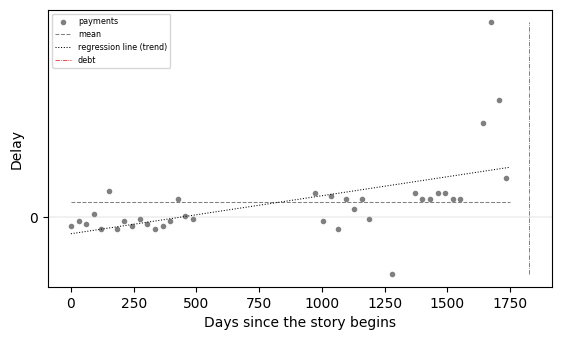

In [13]:
story_id = 116806281

story = stories.filter(pc.field(PaymentStoriesColumns.StoryId.name) == story_id).to_pylist()[0]
payments = groups.filter(pc.field(PaymentGroupsColumns.StoryId.name) == story_id).select([
    PaymentGroupsColumns.StoryTimeline.name,
    PaymentGroupsColumns.DelayDaysScaled.name
]).to_pydict()

a0 = story[PaymentStoriesColumns.TendencyConstant_ForDelay.name]
a1 = story[PaymentStoriesColumns.TendencyCoefficient_ForDelay.name]
duration = story[PaymentStoriesColumns.Duration.name]
mean = story[PaymentStoriesColumns.ScaledDelayMean.name]

fig, ax = plt.subplots(figsize=(6.5, 3.6))
ax.scatter(
    x=payments[PaymentGroupsColumns.StoryTimeline.name],
    y=payments[PaymentGroupsColumns.DelayDaysScaled.name],
    marker=".", color='gray', label='payments'
)
ax.plot(
    [0, duration],
    [mean, mean],
    color='gray', linestyle='--', lw=0.75, label='mean'
)
ax.plot(
    [0, duration],
    [a0, a0 + a1*duration],
    color='black', linestyle='dotted', lw=0.75, label='regression line (trend)'
)
if story[PaymentStoriesColumns.LaterDebtMinDaysToValidFrom.name] > 0:
    debt_x = max(payments[PaymentGroupsColumns.StoryTimeline.name]) + story[PaymentStoriesColumns.LaterDebtMinDaysToValidFrom.name]
    ax.plot(
        [debt_x, debt_x], 
        [min(payments[PaymentGroupsColumns.DelayDaysScaled.name]), max(payments[PaymentGroupsColumns.DelayDaysScaled.name])],
        color='red', lw=0.5, linestyle='-.', label='debt'
    )

ax.grid(axis='y', which='major', lw=0.25)
ax.set_yticks([0])
ax.set_ylabel("Delay")
ax.set_xlabel("Days since the story begins")
ax.legend(fontsize='xx-small')

___

## Problem of wrong timestamp 

In [3]:
codename = 'Mentdis'
stories = pq.read_table(payment_stories_file(input_code, codename))
groups = pq.read_table(payments_grouped_by_stories_file(input_code, codename))

In [4]:
groups.filter(pc.field('legal_entity_id') == 7783117).to_pandas()

,pd_id,legal_entity_id,due_date,delay_days,invoiced_amount,prior_credit_status_max,story_id,dividing_credit_status,dividing_days_to_debt,delay_days_scaled,invoiced_amount_scaled,severity,days_since_story_begins
0,116805595,7783117,2020-09-30,2,133,NaN,116805597,0,NaN,0.131632,-0.159658,0.218945,0
1,116805596,7783117,2020-11-30,1,63,NaN,116805597,0,NaN,0.042903,-0.511417,0.056270,61
2,116805597,7783117,2020-12-31,-1,73,NaN,116805597,0,NaN,-0.134554,-0.461166,-0.183237,92


In [12]:
groups.group_by('story_id').aggregate([('days_since_story_begins', 'min')]).filter(pc.field('days_since_story_begins_min') != 0).to_pandas()

,story_id,days_since_story_begins_min


In [13]:
groups.filter(pc.field('story_id') == 116805502).to_pandas()

,pd_id,legal_entity_id,due_date,delay_days,invoiced_amount,prior_credit_status_max,story_id,dividing_credit_status,dividing_days_to_debt,delay_days_scaled,invoiced_amount_scaled,severity,days_since_story_begins
0,116805448,7780866,2014-11-30,-3,103,NaN,116805502,0,NaN,-0.312011,-0.310412,-0.471936,0
1,116805449,7780866,2015-02-28,-2,89,NaN,116805502,0,NaN,-0.223282,-0.380764,-0.322020,90
2,116805450,7780866,2015-03-31,-1,83,NaN,116805502,0,NaN,-0.134554,-0.410914,-0.189998,121
3,116805451,7780866,2015-04-30,-1,179,NaN,116805502,0,NaN,-0.134554,0.071498,-0.254909,151
4,116805452,7780866,2015-05-31,-3,92,NaN,116805502,0,NaN,-0.312011,-0.365688,-0.454689,182
5,116805453,7780866,2015-06-30,-1,88,NaN,116805502,0,NaN,-0.134554,-0.385789,-0.193379,212
6,116805454,7780866,2015-07-31,-1,162,NaN,116805502,0,NaN,-0.134554,-0.013929,-0.243414,243
7,116805455,7780866,2015-08-31,-3,101,NaN,116805502,0,NaN,-0.312011,-0.320462,-0.468800,274
8,116805456,7780866,2015-09-30,-1,184,NaN,116805502,0,NaN,-0.134554,0.096623,-0.258289,304
9,116805457,7780866,2015-10-31,-2,112,NaN,116805502,0,NaN,-0.223282,-0.265186,-0.347827,335


# Severity explained

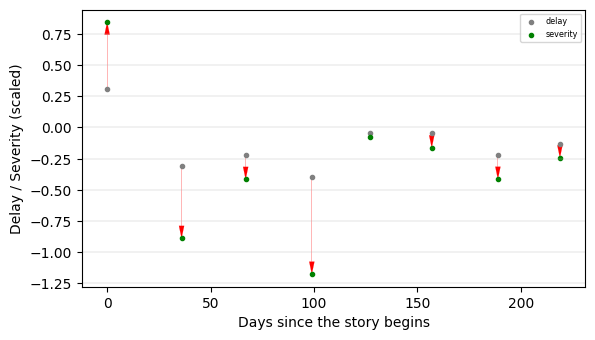

In [48]:
story_id = 116855050

story = stories.filter(pc.field(PaymentStoriesColumns.StoryId.name) == story_id).to_pylist()[0]
payments = groups.filter(pc.field(PaymentGroupsColumns.StoryId.name) == story_id).select([
    PaymentGroupsColumns.StoryTimeline.name,
    PaymentGroupsColumns.DelayDaysScaled.name,
    PaymentGroupsColumns.Severity.name
]).to_pydict()

a0 = story[PaymentStoriesColumns.TendencyConstant_ForDelay.name]
a1 = story[PaymentStoriesColumns.TendencyCoefficient_ForDelay.name]
duration = story[PaymentStoriesColumns.Duration.name]
mean = story[PaymentStoriesColumns.ScaledDelayMean.name]

fig, ax = plt.subplots(figsize=(6.5, 3.6))
# fig, ax = plt.subplots(figsize=(12.5, 6.6))


for _tl, _d, _s in zip(payments[PaymentGroupsColumns.StoryTimeline.name], payments[PaymentGroupsColumns.DelayDaysScaled.name], payments[PaymentGroupsColumns.Severity.name]):
    if abs(_s-_d) > 0.1:
        ax.arrow(x=_tl, y=_d, dx=0, dy=_s-_d, color='red', length_includes_head=True, head_width=2.5, head_length=0.1, lw=0.1)

ax.scatter(
    x=payments[PaymentGroupsColumns.StoryTimeline.name],
    y=payments[PaymentGroupsColumns.DelayDaysScaled.name],
    marker=".", color='gray', label='delay'
)
ax.scatter(
    x=payments[PaymentGroupsColumns.StoryTimeline.name],
    y=payments[PaymentGroupsColumns.Severity.name],
    marker=".", color='green', label='severity'
)


ax.grid(axis='y', which='major', lw=0.25)
ax.set_ylabel("Delay / Severity (scaled)")
ax.set_xlabel("Days since the story begins")
ax.legend(fontsize='xx-small')

# Hipotheses explained

## Mean of severity or delay

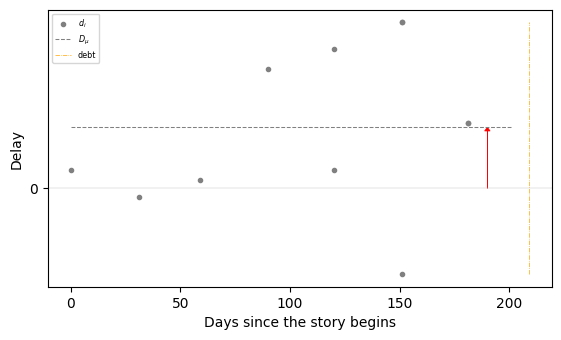

In [56]:
story_id = 116854026

story = stories.filter(pc.field(PaymentStoriesColumns.StoryId.name) == story_id).to_pylist()[0]
payments = groups.filter(pc.field(PaymentGroupsColumns.StoryId.name) == story_id).select([
    PaymentGroupsColumns.StoryTimeline.name,
    PaymentGroupsColumns.DelayDaysScaled.name
]).to_pydict()

a0 = story[PaymentStoriesColumns.TendencyConstant_ForDelay.name]
a1 = story[PaymentStoriesColumns.TendencyCoefficient_ForDelay.name]
duration = story[PaymentStoriesColumns.Duration.name]
mean = story[PaymentStoriesColumns.ScaledDelayMean.name]

fig, ax = plt.subplots(figsize=(6.5, 3.6))
ax.scatter(
    x=payments[PaymentGroupsColumns.StoryTimeline.name],
    y=payments[PaymentGroupsColumns.DelayDaysScaled.name],
    marker=".", color='gray', label='$d_i$'
)
ax.plot(
    [0, duration],
    [mean, mean],
    color='gray', linestyle='--', lw=0.75, label='$D_{\mu}$'
)
ax.arrow(
    x = 1.05*max(payments[PaymentGroupsColumns.StoryTimeline.name]),
    y = 0,
    dx = 0, dy = mean, 
    color='red', length_includes_head=True, 
    head_width=2.5, head_length=0.1, lw=0.5
)

if story[PaymentStoriesColumns.LaterDebtMinDaysToValidFrom.name] > 0:
    debt_x = max(payments[PaymentGroupsColumns.StoryTimeline.name]) + story[PaymentStoriesColumns.LaterDebtMinDaysToValidFrom.name]
    ax.plot(
        [debt_x, debt_x], 
        [min(payments[PaymentGroupsColumns.DelayDaysScaled.name]), max(payments[PaymentGroupsColumns.DelayDaysScaled.name])],
        color='orange', lw=0.5, linestyle='-.', label='debt'
    )

ax.grid(axis='y', which='major', lw=0.25)
ax.set_yticks([0])
ax.set_ylabel("Delay")
ax.set_xlabel("Days since the story begins")
ax.legend(fontsize='xx-small')

## Tendency - regression coefficient 

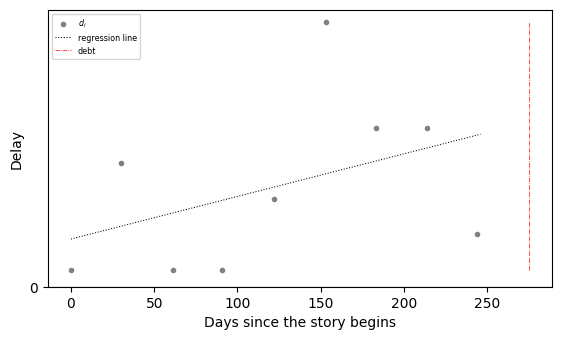

In [72]:
story_id = 116861844 # 116855060

story = stories.filter(pc.field(PaymentStoriesColumns.StoryId.name) == story_id).to_pylist()[0]
payments = groups.filter(pc.field(PaymentGroupsColumns.StoryId.name) == story_id).select([
    PaymentGroupsColumns.StoryTimeline.name,
    PaymentGroupsColumns.DelayDaysScaled.name
]).to_pydict()

a0 = story[PaymentStoriesColumns.TendencyConstant_ForDelay.name]
a1 = story[PaymentStoriesColumns.TendencyCoefficient_ForDelay.name]
duration = story[PaymentStoriesColumns.Duration.name]
mean = story[PaymentStoriesColumns.ScaledDelayMean.name]

fig, ax = plt.subplots(figsize=(6.5, 3.6))
ax.scatter(
    x=payments[PaymentGroupsColumns.StoryTimeline.name],
    y=payments[PaymentGroupsColumns.DelayDaysScaled.name],
    marker=".", color='gray', label='$d_i$'
)
ax.plot(
    [0, duration],
    [a0, a0 + a1*duration],
    color='black', linestyle='dotted', lw=0.75, label='regression line'
)
if story[PaymentStoriesColumns.LaterDebtMinDaysToValidFrom.name] > 0:
    debt_x = max(payments[PaymentGroupsColumns.StoryTimeline.name]) + story[PaymentStoriesColumns.LaterDebtMinDaysToValidFrom.name]
    ax.plot(
        [debt_x, debt_x], 
        [min(payments[PaymentGroupsColumns.DelayDaysScaled.name]), max(payments[PaymentGroupsColumns.DelayDaysScaled.name])],
        color='red', lw=0.5, linestyle='-.', label='debt'
    )
    
ax.grid(axis='y', which='major', lw=0.25)
ax.set_yticks([0])
ax.set_ylabel("Delay")
ax.set_xlabel("Days since the story begins")
ax.legend(fontsize='xx-small')

## Tendency - value 

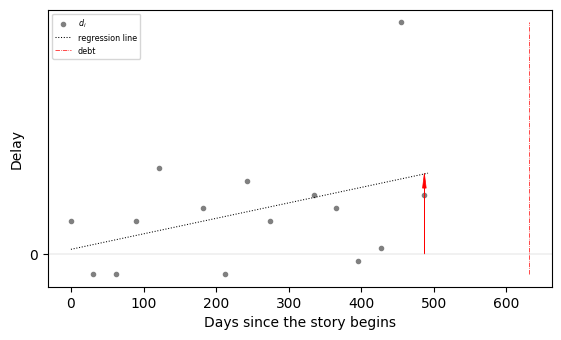

In [79]:
story_id = 116545831

story = stories.filter(pc.field(PaymentStoriesColumns.StoryId.name) == story_id).to_pylist()[0]
payments = groups.filter(pc.field(PaymentGroupsColumns.StoryId.name) == story_id).select([
    PaymentGroupsColumns.StoryTimeline.name,
    PaymentGroupsColumns.DelayDaysScaled.name
]).to_pydict()

a0 = story[PaymentStoriesColumns.TendencyConstant_ForDelay.name]
a1 = story[PaymentStoriesColumns.TendencyCoefficient_ForDelay.name]
duration = story[PaymentStoriesColumns.Duration.name]
mean = story[PaymentStoriesColumns.ScaledDelayMean.name]

fig, ax = plt.subplots(figsize=(6.5, 3.6))
ax.scatter(
    x=payments[PaymentGroupsColumns.StoryTimeline.name],
    y=payments[PaymentGroupsColumns.DelayDaysScaled.name],
    marker=".", color='gray', label='$d_i$'
)
ax.plot(
    [0, duration],
    [a0, a0 + a1*duration],
    color='black', linestyle='dotted', lw=0.75, label='regression line'
)

ax.arrow(
    x = max(payments[PaymentGroupsColumns.StoryTimeline.name]),
    y = 0,
    dx = 0, dy = a0 + a1*duration, 
    color='red', length_includes_head=True, 
    head_width=5, head_length=0.1, lw=0.5
)

if story[PaymentStoriesColumns.LaterDebtMinDaysToValidFrom.name] > 0:
    debt_x = max(payments[PaymentGroupsColumns.StoryTimeline.name]) + story[PaymentStoriesColumns.LaterDebtMinDaysToValidFrom.name]
    ax.plot(
        [debt_x, debt_x], 
        [min(payments[PaymentGroupsColumns.DelayDaysScaled.name]), max(payments[PaymentGroupsColumns.DelayDaysScaled.name])],
        color='red', lw=0.5, linestyle='-.', label='debt'
    )
    
ax.grid(axis='y', which='major', lw=0.25)
ax.set_yticks([0])
ax.set_ylabel("Delay")
ax.set_xlabel("Days since the story begins")
ax.legend(fontsize='xx-small')


# Analysis result overview

In [4]:
report = pd.read_csv(report_predictors(input_code), index_col=[0]).merge(
    pd.read_csv(report_overview_file(input_code), index_col=[0]), left_index=True, right_index=True)

In [8]:
report

,stories-count,story-length-mean,story-duration-mean,stories-per-entity,risk-rate,significant-risk-rate,delay-days-scaled-mean-mean,delay-days-scaled-mean-median,delay-days-scaled-mean-stddev,delay-days-scaled-mean-count-valid,delay-days-scaled-mean-denotes-any-risk-ROC-AUC,delay-days-scaled-mean-denotes-any-risk-F1-max,delay-days-scaled-mean-denotes-any-risk-F1-max-threshold,delay-days-scaled-mean-denotes-significant-risk-ROC-AUC,delay-days-scaled-mean-denotes-significant-risk-F1-max,...,sociodemographic-m-w-ratio,sociodemographic-unknown-gender-ratio,amount-mean,amount-stddev,amount-count-unknown,amount-count-too-high,payment-days-diff-mean,payment-days-diff-stddev,payment-prepaid-days-mean,payment-prepaid-days-stddev,payment-prepaid-days-count,payment-delayed-days-mean,payment-delayed-days-stddev,payment-delayed-days-count,payment-on-time-count
Adbouti,13029,1.974288,81.506639,1.015352,0.014353,0.003224,0.109259,-0.055034,0.797210,2824,0.689535,0.201550,1.186927,0.664783,0.051948,...,1.680527,0.095698,3308.265607,8797.254821,4,57,4.354780,34.527702,-17.379260,10.229324,13616,30.642819,36.227364,11378,729
Addis,2990222,23.315490,296.394972,1.038598,0.029681,0.007486,-0.504798,0.096761,1.235726,2092088,0.443746,0.074729,-4.211975,0.479706,0.028503,...,1.058606,0.003681,NaN,NaN,69718491,0,-1.061049,5.721659,-29.819211,2.170643,2513295,34.444642,53.593544,28153,67177043
Adiningo,6939,1.221069,8.176250,1.004197,0.010808,0.003747,0.049623,-0.132726,1.073876,676,0.820233,0.578947,1.467140,0.715701,0.235294,...,1.122557,0.009986,412.531912,3842.862298,9,19,-16.192848,21.372268,-21.231702,8.766257,7501,24.372376,42.002151,905,67
Alparal,11088,2.074044,190.859758,1.009928,0.010462,0.003066,-0.028669,-0.193126,0.686566,3775,0.731248,0.172107,0.975639,0.812908,0.093023,...,1.724208,0.028327,2018.771620,5792.882308,0,9,-12.813845,22.105732,-21.174070,7.927887,18326,21.377605,28.910181,4367,304
Apacun,1002391,4.089650,506.360243,1.131597,0.083885,0.017536,NaN,NaN,NaN,0,0.000000,NaN,1.000000,0.000000,NaN,...,0.346273,0.006999,NaN,NaN,4099428,0,-30.000000,0.000000,-30.000000,0.000000,4099428,NaN,NaN,0,0
Artersy,11513,4.575436,314.602536,1.041806,0.062972,0.018848,0.177627,-0.211968,1.221399,5145,0.771653,0.403315,2.744031,0.845004,0.341176,...,0.964951,0.188309,213.110242,432.671182,11,0,1.853484,51.076075,-16.589590,8.460042,37789,51.265832,78.618419,14133,755
Beracdi,109868,2.210671,161.793734,1.020234,0.020315,0.004560,0.028095,-0.106876,0.825274,38658,0.755492,0.269363,1.175392,0.734298,0.126468,...,0.816743,0.032102,111.066690,141.842914,57,0,-4.983576,20.354774,-14.892201,7.825324,162135,17.068906,23.878291,70545,10202
Berapes,130549,1.915128,166.534765,1.013839,0.024251,0.001938,-0.008542,-0.104747,0.750757,49081,0.739832,0.329494,0.939665,0.727605,0.063679,...,0.245769,0.003052,91.760123,80.375588,11,0,1.486133,13.931091,-4.608734,2.755378,119696,8.398212,18.560598,109929,20393
Bernev,306267,4.286991,422.759533,1.088992,0.075833,0.023653,NaN,NaN,NaN,0,0.000000,NaN,1.000000,0.000000,NaN,...,0.515905,0.003684,125.175306,186.093391,75,0,0.000000,0.000000,NaN,NaN,0,NaN,NaN,0,1312964
Bertleu,1413,14.087049,497.378627,1.041268,0.034678,0.007077,-0.159532,-0.249453,0.711025,960,0.762443,0.312925,0.575525,0.895615,0.285714,...,16.970149,0.112749,1521.959469,5501.688092,0,19,-11.816780,23.433343,-24.359151,12.496976,12343,9.506463,23.603795,6885,677


## Biggest sources ROC

In [18]:

report.sort_values(
    [OverviewReportColNames.RecordsCountWithoutOutliers], 
    ascending=False)[[
    OverviewReportColNames.RecordsCountWithoutOutliers, 
    StoriesPerformanceReportColNames.StoriesCount,
    StoriesPerformanceReportColNames.PredictorPerformanceROCAUC(PaymentStoriesColumns.ScaledDelayMean, PaymentStoriesColumns.DenotesAnyRisk),
    StoriesPerformanceReportColNames.PredictorPerformanceROCAUC(PaymentStoriesColumns.SeverityMean, PaymentStoriesColumns.DenotesAnyRisk),
    StoriesPerformanceReportColNames.PredictorPerformanceROCAUC(PaymentStoriesColumns.Tendency_ForDelay, PaymentStoriesColumns.DenotesAnyRisk),
    StoriesPerformanceReportColNames.PredictorPerformanceROCAUC(PaymentStoriesColumns.Tendency_ForSeverity, PaymentStoriesColumns.DenotesAnyRisk),    
]].rename(
    columns={
        OverviewReportColNames.RecordsCountWithoutOutliers: 'Payments',
        StoriesPerformanceReportColNames.StoriesCount: 'Stories',
        StoriesPerformanceReportColNames.PredictorPerformanceROCAUC(PaymentStoriesColumns.ScaledDelayMean, PaymentStoriesColumns.DenotesAnyRisk): '$D_{\mu}$',
        StoriesPerformanceReportColNames.PredictorPerformanceROCAUC(PaymentStoriesColumns.SeverityMean, PaymentStoriesColumns.DenotesAnyRisk): '$S_{\mu}$',
        StoriesPerformanceReportColNames.PredictorPerformanceROCAUC(PaymentStoriesColumns.Tendency_ForDelay, PaymentStoriesColumns.DenotesAnyRisk): '$\hat{D}$',
        StoriesPerformanceReportColNames.PredictorPerformanceROCAUC(PaymentStoriesColumns.Tendency_ForSeverity, PaymentStoriesColumns.DenotesAnyRisk): '$\hat{S}$'    
    }
).head(50)

,Payments,Stories,$D_{\mu}$,$S_{\mu}$,$\hat{D}$,$\hat{S}$
Addis,69718491,2990222,0.443746,0.443746,0.347495,0.347495
Estry,36659140,1752963,0.617915,0.612668,0.569114,0.560599
Ganpe,14364531,1028400,0.000000,0.000000,0.000000,0.000000
Tionse,8359220,1172365,0.713176,0.713687,0.662067,0.660282
Parfae,8135856,1375255,0.702122,0.697699,0.677408,0.672657
Otheso,6501804,911976,0.000000,0.000000,0.000000,0.000000
Ningui,4922236,926838,0.000000,0.000000,0.000000,0.000000
Apacun,4099428,1002391,0.000000,0.000000,0.000000,0.000000
Everna,3884437,1571728,0.741491,0.730293,0.698885,0.687302
Picfio,3311629,160143,0.652614,0.654789,0.618930,0.620271


## Predictors comparison

In [9]:
H1 = StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMax(PaymentStoriesColumns.ScaledDelayMean, PaymentStoriesColumns.DenotesAnyRisk)
H2 = StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMax(PaymentStoriesColumns.SeverityMean, PaymentStoriesColumns.DenotesAnyRisk)
H3 = StoriesPerformanceReportColNames.PredictorPerformanceF1_00(PaymentStoriesColumns.TendencyCoefficient_ForDelay, PaymentStoriesColumns.DenotesAnyRisk)
H4 = StoriesPerformanceReportColNames.PredictorPerformanceF1_00(PaymentStoriesColumns.TendencyCoefficient_ForSeverity, PaymentStoriesColumns.DenotesAnyRisk)    
H5 = StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMax(PaymentStoriesColumns.Tendency_ForDelay, PaymentStoriesColumns.DenotesAnyRisk)
H6 = StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMax(PaymentStoriesColumns.Tendency_ForSeverity, PaymentStoriesColumns.DenotesAnyRisk) 
CNT = StoriesPerformanceReportColNames.PredictorCountValid(PaymentStoriesColumns.ScaledDelayMean)

H = [H1, H2, H3, H4, H5, H6]

report_best_F1 = report.loc[report[CNT] > 2000].filter(
    items=H+[CNT], axis='columns')
report_best_F1[CNT] = report_best_F1[CNT]/1000

sources = []
for col in H:
    _best = report_best_F1.sort_values(col, ascending=False).head(25).index
    for _src in _best:
        if _src not in sources:
            sources.append(_src)

report_best_F1 = report_best_F1.filter(items=sources, axis='index')
report_best_F1['F1_sum'] = report_best_F1.filter(items=H, axis='columns').sum(axis=1)
report_best_F1.sort_values(['F1_sum'], ascending=False).filter(items=[CNT]+H, axis='columns').rename(columns={
    CNT: 'Stories (k)',
    H1: r'\makecell{$H_1$\\$F_1^max$\\$D_{\mu}$}',
    H2: r'\makecell{$H_2$\\$F_1^max$\\$S_{\mu}$}',
    H3: r'\makecell{$H_3$\\$F_1$\\$D_{a_1}$}',
    H4: r'\makecell{$H_4$\\$F_1$\\$S_{a_1}$}',
    H5: r'\makecell{$H_5$\\$F_1^max$\\$\hat{D}$}',
    H6: r'\makecell{$H_6$\\$F_1^max$\\$\hat{S}$}'
})

# '',
# '$S_{\mu}$',
# '$\hat{D}$',
# '$\hat{S}$'    


,Stories (k),\makecell{$H_1$\\$F_1^max$\\$D_{\mu}$},\makecell{$H_2$\\$F_1^max$\\$S_{\mu}$},\makecell{$H_3$\\$F_1$\\$D_{a_1}$},\makecell{$H_4$\\$F_1$\\$S_{a_1}$},\makecell{$H_5$\\$F_1^max$\\$\hat{D}$},\makecell{$H_6$\\$F_1^max$\\$\hat{S}$}
Blebout,8.873,0.494780,0.493760,0.256921,0.265763,0.446399,0.447855
Mentdis,24.335,0.419113,0.438156,0.216279,0.224452,0.416811,0.435232
Artersy,5.145,0.403315,0.397633,0.137717,0.138056,0.415698,0.410615
Estry,1652.894,0.379956,0.388834,0.235788,0.234379,0.308214,0.337977
Ipoapfi,72.581,0.346497,0.349264,0.213234,0.217786,0.371686,0.374380
Paiafei,71.518,0.408530,0.406098,0.120181,0.122301,0.392331,0.391777
Sirient,24.209,0.373713,0.384203,0.051840,0.049625,0.423240,0.424128
Vertlei,3.943,0.335421,0.308418,0.146096,0.161398,0.308411,0.293878
Tersdif,44.669,0.326818,0.345421,0.083728,0.085106,0.313789,0.322343
Berapes,49.081,0.329494,0.318878,0.068125,0.068237,0.347718,0.340541


In [23]:
report.loc[report[StoriesPerformanceReportColNames.StoriesCount] > 1000].sort_values(
    [StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMax(PaymentStoriesColumns.ScaledDelayMean, PaymentStoriesColumns.DenotesAnyRisk)], 
    ascending=False)[[
    OverviewReportColNames.RecordsCountWithoutOutliers, 
    StoriesPerformanceReportColNames.StoriesCount,
    StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMax(PaymentStoriesColumns.ScaledDelayMean, PaymentStoriesColumns.DenotesAnyRisk),
    StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMax(PaymentStoriesColumns.SeverityMean, PaymentStoriesColumns.DenotesAnyRisk),
    StoriesPerformanceReportColNames.PredictorPerformanceF1_00(PaymentStoriesColumns.TendencyCoefficient_ForDelay, PaymentStoriesColumns.DenotesAnyRisk),
    StoriesPerformanceReportColNames.PredictorPerformanceF1_00(PaymentStoriesColumns.TendencyCoefficient_ForSeverity, PaymentStoriesColumns.DenotesAnyRisk),    
    StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMax(PaymentStoriesColumns.Tendency_ForDelay, PaymentStoriesColumns.DenotesAnyRisk),
    StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMax(PaymentStoriesColumns.Tendency_ForSeverity, PaymentStoriesColumns.DenotesAnyRisk),    
]].rename(
    columns={
        OverviewReportColNames.RecordsCountWithoutOutliers: 'Payments',
        StoriesPerformanceReportColNames.StoriesCount: 'Stories',
        StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMax(PaymentStoriesColumns.ScaledDelayMean, PaymentStoriesColumns.DenotesAnyRisk): '$H_1$ $D_{\mu}$',
        StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMax(PaymentStoriesColumns.SeverityMean, PaymentStoriesColumns.DenotesAnyRisk): '$S_{\mu}$',
        StoriesPerformanceReportColNames.PredictorPerformanceF1_00(PaymentStoriesColumns.TendencyCoefficient_ForDelay, PaymentStoriesColumns.DenotesAnyRisk): '$\hat{D}$',
        StoriesPerformanceReportColNames.PredictorPerformanceF1_00(PaymentStoriesColumns.TendencyCoefficient_ForSeverity, PaymentStoriesColumns.DenotesAnyRisk): '$\hat{S}$',   
        StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMax(PaymentStoriesColumns.Tendency_ForDelay, PaymentStoriesColumns.DenotesAnyRisk): '$\hat{D}$',
        StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMax(PaymentStoriesColumns.Tendency_ForSeverity, PaymentStoriesColumns.DenotesAnyRisk): '$\hat{S}$'    
    }
).head(50)

,Payments,Stories,$H_1$ $D_{\mu}$,$S_{\mu}$,$\hat{D}$,$\hat{S}$,$\hat{D}$,$\hat{S}$
Adiningo,8473,6939,0.578947,0.631579,0.171875,0.129032,0.387097,0.533333
Tainpeo,21662,1445,0.536232,0.506024,0.137931,0.140351,0.513514,0.500000
Blebout,339046,10261,0.494780,0.493760,0.256921,0.265763,0.446399,0.447855
Merwaalo,2209,1193,0.444444,0.444444,0.017857,0.016667,0.400000,0.400000
Nyurever,1566,1469,0.424242,0.482759,0.307692,0.285714,0.357143,0.357143
Mentdis,640145,31613,0.419113,0.438156,0.216279,0.224452,0.416811,0.435232
Ganrehap,5994,4315,0.417910,0.411765,0.096552,0.103896,0.400000,0.413793
Evmempe,18913,2304,0.413408,0.386139,0.161491,0.154403,0.351220,0.338095
Paiafei,433177,178074,0.408530,0.406098,0.120181,0.122301,0.392331,0.391777
Artersy,52677,11513,0.403315,0.397633,0.137717,0.138056,0.415698,0.410615


## Predictor performance details - ROC curve

In [7]:
source_codename = 'Blebout'
evaluator = PaymentStoriesPerformanceEvaluator(payment_stories_file(input_code, source_codename), source_codename)
report = pd.read_csv(report_predictors(input_code), index_col=[0]).merge(
    pd.read_csv(report_overview_file(input_code), index_col=[0]), left_index=True, right_index=True).filter(items=[source_codename], axis='index')
FPR = 'False Positive Rate'
TPR = 'True Positive Rate'

In [8]:
roc_h1 = evaluator.roc_curve(
    predictor_col=PaymentStoriesColumns.ScaledDelayMean.name, 
    steps=200, 
    actual_col=PaymentStoriesColumns.DenotesAnyRisk.name
)

roc_h2 = evaluator.roc_curve(
    predictor_col=PaymentStoriesColumns.SeverityMean.name, 
    steps=200, 
    actual_col=PaymentStoriesColumns.DenotesAnyRisk.name
)

roc_h3 = evaluator.roc_curve(
    predictor_col=PaymentStoriesColumns.Tendency_ForDelay.name, 
    steps=200, 
    actual_col=PaymentStoriesColumns.DenotesAnyRisk.name
)

roc_h4 = evaluator.roc_curve(
    predictor_col=PaymentStoriesColumns.Tendency_ForSeverity.name, 
    steps=200, 
    actual_col=PaymentStoriesColumns.DenotesAnyRisk.name
)

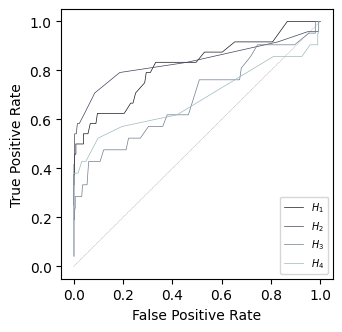

In [113]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.plot([0, 1], [0, 1], lw=0.25, color='gray', linestyle='--')
colormap = mpl.colormaps['bone']

ax.plot(roc_h1[FPR], roc_h1[TPR], lw=0.5, color=colormap(0.1), label='$H_1$')
ax.plot(roc_h2[FPR], roc_h2[TPR], lw=0.5, color=colormap(0.3), label='$H_2$')
ax.plot(roc_h3[FPR], roc_h3[TPR], lw=0.5, color=colormap(0.5), label='$H_3$')
ax.plot(roc_h4[FPR], roc_h4[TPR], lw=0.5, color=colormap(0.7), label='$H_4$')

ax.set_ylabel(TPR)
ax.set_xlabel(FPR)
ax.legend(fontsize='x-small', loc='lower right')


Text(0.5, 0.02, 'False Positive Rate')

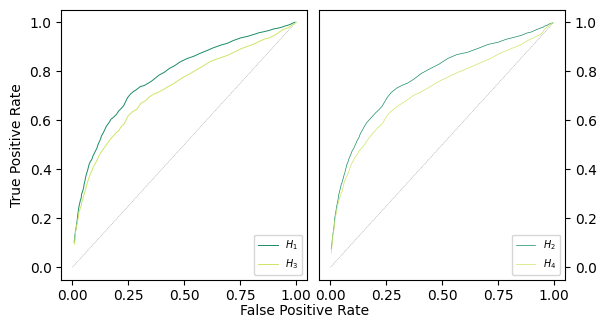

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.5), gridspec_kw={"wspace": 0.05})

axs[0].plot([0, 1], [0, 1], lw=0.25, color='gray', linestyle='--')
axs[1].plot([0, 1], [0, 1], lw=0.25, color='gray', linestyle='--')
colormap = mpl.colormaps['summer']

axs[0].plot(roc_h1[FPR], roc_h1[TPR], lw=0.7, color=colormap(0.1), label='$H_1$')
axs[0].plot(roc_h3[FPR], roc_h3[TPR], lw=0.7, color=colormap(0.8), label='$H_3$')
axs[1].plot(roc_h2[FPR], roc_h2[TPR], lw=0.5, color=colormap(0.1), label='$H_2$')
axs[1].plot(roc_h4[FPR], roc_h4[TPR], lw=0.5, color=colormap(0.8), label='$H_4$')

axs[0].set_ylabel(TPR)
axs[1].yaxis.tick_right()

axs[0].legend(fontsize='x-small', loc='lower right')
axs[1].legend(fontsize='x-small', loc='lower right')

fig.text(0.5, 0.02, FPR, ha='center', va='center')

## Predictor details: summary table

In [3]:
source_codename = 'Adiningo'
evaluator = PaymentStoriesPerformanceEvaluator(payment_stories_file(input_code, source_codename), source_codename)
report = pd.read_csv(report_predictors(input_code), index_col=[0]).merge(
    pd.read_csv(report_overview_file(input_code), index_col=[0]), left_index=True, right_index=True).filter(items=[source_codename], axis='index')

In [4]:
_predictor_columns = [
    PaymentStoriesColumns.ScaledDelayMean, 
    PaymentStoriesColumns.Tendency_ForDelay, 
    PaymentStoriesColumns.SeverityMean, 
    PaymentStoriesColumns.Tendency_ForSeverity
]
_actual_column = PaymentStoriesColumns.DenotesAnyRisk
tab1 = pd.DataFrame({
    'AUC': [report[StoriesPerformanceReportColNames.PredictorPerformanceROCAUC(_pc, _actual_column)][0] for _pc in _predictor_columns],
    'F1max': [report[StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMax(_pc, _actual_column)][0] for _pc in _predictor_columns],
    'TPR': [evaluator.true_positive_rate(_pc.name, report[StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMaxTh(_pc, _actual_column)][0], _actual_column.name) for _pc in _predictor_columns],
    'PPV': [evaluator.precision(_pc.name, report[StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMaxTh(_pc, _actual_column)][0], _actual_column.name) for _pc in _predictor_columns],
    'ACC': [evaluator.accuracy(_pc.name, report[StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMaxTh(_pc, _actual_column)][0], _actual_column.name) for _pc in _predictor_columns],
}, index=['H1', 'H5', 'H2', 'H4'])
cm = evaluator.confusion_matrix(_predictor_columns[0].name, report[StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMaxTh(_predictor_columns[0], _actual_column)][0], _actual_column.name)

In [5]:
cm

((11, 13), (3, 649))

In [6]:
tab1

,AUC,F1max,TPR,PPV,ACC
H1,0.820233,0.578947,0.458333,0.785714,0.976331
H5,0.682697,0.387097,0.285714,0.600000,0.969697
H2,0.826240,0.631579,0.500000,0.857143,0.979290
H4,0.697077,0.533333,0.380952,0.888889,0.977671


In [131]:
evaluator.stories().to_pandas()

,story_id,pd_id_min,legal_entity_id,credit_status_start,credit_status_stop,later_debts_min_days_to_valid_from,due_date_first,due_date_last,story_duration_days,payments_count,delay_days_scaled_mean,invoiced_amount_scaled_mean,severity_mean,days_since_begin_mean,denotes_any_risk,denotes_significant_risk,regression_line_a1_for_delay,regression_line_a1_for_severity,regression_line_a0_for_delay,regression_line_a0_for_severity,delay_days_tendency,severity_tendency,regression_line_rsquare_for_delay,regression_line_rsquare_for_severity
0,176109594,176109593,68597,NaN,0,NaN,2020-09-23,2020-09-25,-12,2,0.149392,-0.256668,0.238542,1.000000,False,False,-0.046790,-0.029799,0.196182,0.268341,0.102602,0.208743,1.000000,1.000000
1,176109603,176109596,76396,NaN,0,NaN,2020-03-05,2022-09-09,890,8,0.172787,0.914309,0.478888,426.625000,False,False,-0.000694,-0.001844,0.469043,1.265383,-0.168433,-0.426976,0.202037,0.168419
2,176109613,176109612,94712,NaN,0,NaN,2020-07-17,2021-03-14,215,2,0.009023,0.559424,-0.107974,120.000000,False,False,-0.003509,-0.008810,0.430130,0.949252,-0.412083,-1.165201,1.000000,1.000000
3,176109618,176109617,108043,NaN,0,NaN,2020-03-28,2021-02-14,296,2,0.219577,0.306551,0.122078,161.500000,False,False,-0.004491,-0.009465,0.944815,1.650712,-0.505662,-1.406555,1.000000,1.000000
4,176109637,176109626,139879,NaN,0,NaN,2020-03-20,2022-08-14,875,12,0.574398,1.925325,2.220795,398.583333,False,False,-0.000274,-0.000639,0.683510,2.475581,0.443431,1.914976,0.008593,0.002350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6934,176118066,176118066,19321851,NaN,0,NaN,2021-11-27,2021-11-27,-10,1,0.289761,-0.153219,0.522902,0.000000,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6935,176118072,176118072,19322756,NaN,0,NaN,2022-10-15,2022-10-15,-24,1,-0.365294,0.364022,-0.848153,0.000000,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6936,176118073,176118073,19323467,3.0,2,434.0,2020-07-10,2020-07-10,24,1,1.880607,0.053677,3.782831,0.000000,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6937,176118074,176118074,19325625,NaN,0,NaN,2020-04-17,2020-04-17,-16,1,0.009023,0.145631,0.018980,0.000000,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## F1 curve 

In [31]:
source_codename = 'Blebout'
evaluator = PaymentStoriesPerformanceEvaluator(payment_stories_file(input_code, source_codename), source_codename)
report = pd.read_csv(report_predictors(input_code), index_col=[0]).merge(
    pd.read_csv(report_overview_file(input_code), index_col=[0]), left_index=True, right_index=True).filter(items=[source_codename], axis='index')

In [23]:
f1c_h1 = evaluator.f1_curve(
    predictor_col=PaymentStoriesColumns.ScaledDelayMean.name, 
    steps=200, 
    actual_col=PaymentStoriesColumns.DenotesAnyRisk.name
)

f1c_h2 = evaluator.f1_curve(
    predictor_col=PaymentStoriesColumns.SeverityMean.name, 
    steps=200, 
    actual_col=PaymentStoriesColumns.DenotesAnyRisk.name
)

f1c_h5 = evaluator.f1_curve(
    predictor_col=PaymentStoriesColumns.Tendency_ForDelay.name, 
    steps=200, 
    actual_col=PaymentStoriesColumns.DenotesAnyRisk.name
)

f1c_h6 = evaluator.f1_curve(
    predictor_col=PaymentStoriesColumns.Tendency_ForSeverity.name, 
    steps=200, 
    actual_col=PaymentStoriesColumns.DenotesAnyRisk.name
)


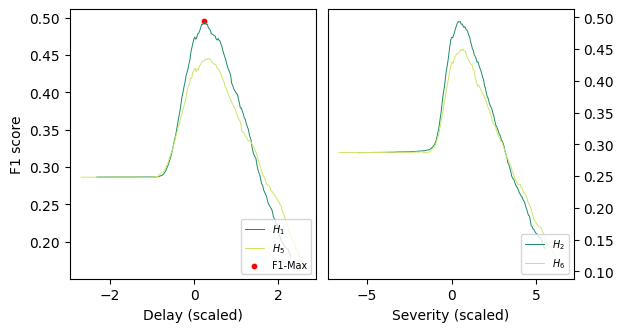

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.5), gridspec_kw={"wspace": 0.05})

colormap = mpl.colormaps['summer']

axs[0].plot(f1c_h1.index, f1c_h1[f1c_h1.columns[0]], lw=0.7, color=colormap(0.1), label='$H_1$')
axs[0].plot(f1c_h5.index, f1c_h5[f1c_h5.columns[0]], lw=0.7, color=colormap(0.8), label='$H_5$')
axs[1].plot(f1c_h2.index, f1c_h2[f1c_h2.columns[0]], lw=0.7, color=colormap(0.1), label='$H_2$')
axs[1].plot(f1c_h6.index, f1c_h6[f1c_h6.columns[0]], lw=0.7, color=colormap(0.8), label='$H_6$')

f1max_y = report[StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMax(PaymentStoriesColumns.ScaledDelayMean, PaymentStoriesColumns.DenotesAnyRisk)][0]
f1max_x = report[StoriesPerformanceReportColNames.PredictorPerformanceF1ScoreMaxTh(PaymentStoriesColumns.ScaledDelayMean, PaymentStoriesColumns.DenotesAnyRisk)][0]
axs[0].scatter([f1max_x],[f1max_y], label='F1-Max', color='red', s=[10])

axs[0].set_ylabel('F1 score')
axs[0].set_xlabel('Delay (scaled)')
axs[1].set_xlabel('Severity (scaled)')

axs[1].yaxis.tick_right()

axs[0].legend(fontsize='x-small', loc='lower right')
axs[1].legend(fontsize='x-small', loc='lower right')



### ROC curve just for presentation

In [7]:
source_codename = 'Blebout'
evaluator = PaymentStoriesPerformanceEvaluator(payment_stories_file(input_code, source_codename), source_codename)
FPR = 'False Positive Rate'
TPR = 'True Positive Rate'


In [ ]:
roc_h1 = evaluator.roc_curve(
    predictor_col=PaymentStoriesColumns.ScaledDelayMean.name, 
    steps=200, 
    actual_col=PaymentStoriesColumns.DenotesAnyRisk.name
)

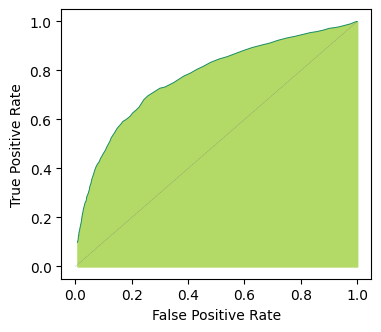

In [17]:
fig, ax = plt.subplots(figsize=(4, 3.5))

ax.plot([0, 1], [0, 1], lw=0.25, color='gray', linestyle='--')
colormap = mpl.colormaps['summer']

ax.plot(roc_h1[FPR], roc_h1[TPR], lw=0.7, color=colormap(0.1), label='$H_1$')
ax.fill_between(roc_h1[FPR], roc_h1[TPR], color=colormap(0.7))

ax.set_ylabel(TPR)
ax.set_xlabel(FPR)

plt.savefig(tex_figure_file('tmp_ROC'))
